In [1]:
# dependencies and configuration
# python3 -m venv sepsis_env
# source sepsis_env/bin/activate
# pip install ipykernel pandas numpy matplotlib seaborn scikit-learn tensorflow imblean umap-learn xgboost lightgbm
# python -m ipykernel install --user --name=sepsis_env --display-name="Python (sepsis)"

# xgboost issue:
# brew install libomp
# ls /opt/homebrew/opt/libomp/lib/libomp.dylib
# export DYLD_LIBRARY_PATH=/opt/homebrew/opt/libomp/lib:$DYLD_LIBRARY_PATH
# python -c "import xgboost; print(xgboost.__version__)"

#  permanent fix: 
# echo 'export DYLD_LIBRARY_PATH=/opt/homebrew/opt/libomp/lib:$DYLD_LIBRARY_PATH' >> ~/.zshrc
# source ~/.zshrc

# MIMIC-IV AKI Clustering: Feature Extraction Pipeline
**Objective**: Extract features from 24h post-AKI for unsupervised clustering

**Author**: June Zhang

**Date**: 2025-12-12  

**MIMIC-IV Version**: 3.1

## 1. Setup & Configuration

In [ ]:
import pandas as pd
import numpy as np
from datetime import timedelta
import warnings
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

MIMIC_PATH = "./physionet.org/files/mimiciv/3.1"
DATA_DIR = "./clustering_output/data"
RESULT_DIR = "./clustering_output/result"
AKI_WINDOW_HOURS = 24
MIN_ICU_STAY_HOURS = 48

Path(DATA_DIR).mkdir(exist_ok=True)
print(f"✓ MIMIC path: {MIMIC_PATH}")
assert os.path.exists(MIMIC_PATH), "MIMIC path not found!"

✓ MIMIC path: /Users/zz005/Documents/github/Sepsis/physionet.org/files/mimiciv/3.1


## 2. Load Core Tables

In [3]:
print("Loading core tables\n" + "="*60)

# ICU stays
icustays = pd.read_csv(f"{MIMIC_PATH}/icu/icustays.csv.gz", parse_dates=['intime', 'outtime'])
icustays['los_hours'] = (icustays['outtime'] - icustays['intime']).dt.total_seconds() / 3600
icustays = icustays[icustays['los_hours'] >= MIN_ICU_STAY_HOURS]
print(f"  ICU stays (≥48h): {len(icustays):,}")

# Patients
patients = pd.read_csv(f"{MIMIC_PATH}/hosp/patients.csv.gz")

# Admissions
admissions = pd.read_csv(f"{MIMIC_PATH}/hosp/admissions.csv.gz", parse_dates=['admittime'])

# Creatinine labs
print("  Loading creatinine measurements\n" + "="*60)
labevents = pd.read_csv(
    f"{MIMIC_PATH}/hosp/labevents.csv.gz",
    parse_dates=['charttime'],
    usecols=['subject_id', 'hadm_id', 'charttime', 'itemid', 'valuenum']
)
cr_labs = labevents[labevents['itemid'] == 50912].copy()  # Creatinine only
print(f"  Creatinine measurements: {len(cr_labs):,}")

Loading core tables
  ICU stays (≥48h): 46,337
  Loading creatinine measurements
  Creatinine measurements: 4,319,091


## 3. Detect AKI (KDIGO Criteria)

In [4]:
print("\nDetecting AKI using KDIGO creatinine criteria\n" + "="*60)

# Merge creatinine with ICU stays
cr_icu = icustays[['stay_id', 'subject_id', 'hadm_id', 'intime', 'outtime']].merge(
    cr_labs, on=['subject_id', 'hadm_id']
)

# Filter to ICU timeframe & valid values
cr_icu = cr_icu[
    (cr_icu['charttime'] >= cr_icu['intime']) &
    (cr_icu['charttime'] <= cr_icu['outtime']) &
    (cr_icu['valuenum'] > 0.1) & (cr_icu['valuenum'] < 20)
].rename(columns={'valuenum': 'creatinine'}).sort_values(['stay_id', 'charttime'])

# Calculate baseline (first Cr within 24h)
cr_icu['hours_from_admit'] = (cr_icu['charttime'] - cr_icu['intime']).dt.total_seconds() / 3600
baseline = cr_icu[cr_icu['hours_from_admit'] <= 24].groupby('stay_id')['creatinine'].first()
cr_icu = cr_icu.merge(baseline.rename('baseline_cr'), on='stay_id')

# KDIGO detection
cr_icu['cr_prev'] = cr_icu.groupby('stay_id')['creatinine'].shift()
cr_icu['time_prev'] = cr_icu.groupby('stay_id')['charttime'].shift()
cr_icu['time_diff'] = (cr_icu['charttime'] - cr_icu['time_prev']).dt.total_seconds() / 3600

# Criterion 1: ≥0.3 increase within 48h
criterion1 = (cr_icu['creatinine'] - cr_icu['cr_prev'] >= 0.3) & (cr_icu['time_diff'] <= 48)

# Criterion 2: ≥1.5× baseline
cr_icu['ratio'] = cr_icu['creatinine'] / cr_icu['baseline_cr']
criterion2 = (cr_icu['ratio'] >= 1.5) & (cr_icu['hours_from_admit'] <= 168)

cr_icu['has_aki'] = criterion1 | criterion2

# Stage
def stage(row):
    if not row['has_aki']: return 0
    r = row['ratio']
    if r >= 3.0 or row['creatinine'] >= 4.0: return 3
    if r >= 2.0: return 2
    return 1

cr_icu['aki_stage'] = cr_icu.apply(stage, axis=1)

# First AKI per stay
aki_cohort = cr_icu[cr_icu['has_aki']].groupby('stay_id').agg({
    'charttime': 'first',
    'aki_stage': 'max',
    'baseline_cr': 'first',
    'creatinine': 'first'
}).rename(columns={'charttime': 'aki_time', 'creatinine': 'aki_cr'}).reset_index()

print(f"\n✓ AKI cases: {len(aki_cohort):,}")
print(f"  Stage 1: {(aki_cohort.aki_stage==1).sum()}")
print(f"  Stage 2: {(aki_cohort.aki_stage==2).sum()}")
print(f"  Stage 3: {(aki_cohort.aki_stage==3).sum()}")


Detecting AKI using KDIGO creatinine criteria

✓ AKI cases: 13,676
  Stage 1: 7621
  Stage 2: 1634
  Stage 3: 4421


## 4. Extract Demographics & Comorbidities

In [5]:
print("\nExtracting demographics\n" + "="*60)

demo = aki_cohort[['stay_id']].merge(
    icustays[['stay_id', 'subject_id', 'hadm_id', 'first_careunit']], on='stay_id'
).merge(
    patients[['subject_id', 'gender', 'anchor_age']], on='subject_id'
).merge(
    admissions[['hadm_id', 'race', 'admission_type', 'admission_location']], on='hadm_id'
).rename(columns={'anchor_age': 'age'})

# Comorbidities from ICD codes
print("  Extracting comorbidities\n" + "="*60)
dx = pd.read_csv(f"{MIMIC_PATH}/hosp/diagnoses_icd.csv.gz", usecols=['hadm_id', 'icd_code', 'icd_version'])
dx = dx[(dx['hadm_id'].isin(demo['hadm_id'])) & (dx['icd_version'] == 10)]

def has_dx(codes, hadm_list, prefixes):
    """Check if any diagnosis matches prefixes for each hadm_id"""
    mask = codes['icd_code'].str.startswith(tuple(prefixes))
    matched = codes[mask]['hadm_id'].unique()
    return pd.Series([1 if h in matched else 0 for h in hadm_list], index=hadm_list)

hadm_list = demo['hadm_id'].values
comorbid = pd.DataFrame({
    'hadm_id': hadm_list,
    'chf': has_dx(dx, hadm_list, ['I50']).values,
    'hypertension': has_dx(dx, hadm_list, ['I10', 'I11', 'I12']).values,
    'diabetes': has_dx(dx, hadm_list, ['E08', 'E09', 'E10', 'E11']).values,
    'ckd': has_dx(dx, hadm_list, ['N18']).values,
    'liver_disease': has_dx(dx, hadm_list, ['K70', 'K71', 'K72', 'K73', 'K74']).values,
    'copd': has_dx(dx, hadm_list, ['J44']).values,
    'malignancy': has_dx(dx, hadm_list, ['C']).values
})

demo = demo.merge(comorbid, on='hadm_id', how='left')
print(f"✓ Demographics: {demo.shape}")


Extracting demographics
  Extracting comorbidities
✓ Demographics: (15394, 16)


## 5. Extract Vital Signs (24h post-AKI)

In [6]:
print("\nExtracting vitals (this takes time)\n" + "="*60)

VITALS = {220045: 'hr', 220052: 'map', 220181: 'map_inv', 220210: 'rr', 223761: 'temp'}

aki_window = aki_cohort[['stay_id', 'aki_time']].copy()
aki_window['end'] = aki_window['aki_time'] + pd.Timedelta(hours=24)

vitals_list = []
for chunk in tqdm(pd.read_csv(
    f"{MIMIC_PATH}/icu/chartevents.csv.gz",
    chunksize=1_000_000,
    usecols=['stay_id', 'charttime', 'itemid', 'valuenum'],
    parse_dates=['charttime']
), desc="Chartevents"):
    chunk = chunk[(chunk['stay_id'].isin(aki_window['stay_id'])) & (chunk['itemid'].isin(VITALS.keys()))]
    if len(chunk) == 0: continue
    
    chunk = chunk.merge(aki_window, on='stay_id')
    chunk = chunk[(chunk['charttime'] >= chunk['aki_time']) & (chunk['charttime'] <= chunk['end'])]
    
    if len(chunk) > 0:
        vitals_list.append(chunk[['stay_id', 'itemid', 'valuenum']])

if vitals_list:
    vitals = pd.concat(vitals_list)
    vitals['vital'] = vitals['itemid'].map(VITALS)
    vitals_agg = vitals.groupby(['stay_id', 'vital'])['valuenum'].agg(['mean', 'min', 'max', 'std']).unstack()
    vitals_agg.columns = ['_'.join(col).strip() for col in vitals_agg.columns]
    vitals_agg = vitals_agg.reset_index()
    print(f"✓ Vitals: {vitals_agg.shape}")
else:
    vitals_agg = pd.DataFrame({'stay_id': aki_cohort['stay_id']})
    print("⚠ No vitals extracted")


Extracting vitals (this takes time)


Chartevents: 433it [03:22,  2.13it/s]

✓ Vitals: (13636, 21)


## 6. Extract Labs (24h post-AKI)

In [7]:
print("\nExtracting labs\n" + "="*60)

LABS = {50912: 'cr', 51006: 'bun', 50822: 'k', 50882: 'hco3', 50813: 'lactate',
        50820: 'ph', 51222: 'hgb', 51265: 'plt', 51301: 'wbc', 50885: 'bili'}

subjects = demo['subject_id'].unique()
labs_all = labevents[(labevents['subject_id'].isin(subjects)) & (labevents['itemid'].isin(LABS.keys()))]

aki_subj = aki_cohort.merge(icustays[['stay_id', 'subject_id']], on='stay_id')[['stay_id', 'subject_id', 'aki_time']]
aki_subj['end'] = aki_subj['aki_time'] + pd.Timedelta(hours=24)

labs_filt = labs_all.merge(aki_subj, on='subject_id')
labs_filt = labs_filt[(labs_filt['charttime'] >= labs_filt['aki_time']) & (labs_filt['charttime'] <= labs_filt['end'])]

labs_filt['lab'] = labs_filt['itemid'].map(LABS)
labs_agg = labs_filt.groupby(['stay_id', 'lab'])['valuenum'].agg(['mean', 'min', 'max']).unstack()
labs_agg.columns = ['_'.join(col).strip() for col in labs_agg.columns]
labs_agg = labs_agg.reset_index()

# BUN/Cr ratio
if 'mean_bun' in labs_agg.columns and 'mean_cr' in labs_agg.columns:
    labs_agg['bun_cr_ratio'] = labs_agg['mean_bun'] / labs_agg['mean_cr'].replace(0, np.nan)

print(f"✓ Labs: {labs_agg.shape}")


Extracting labs
✓ Labs: (13676, 32)


## 7. Merge Final Dataset

In [ ]:
print("\nMerging final dataset\n" + "="*60)

final = aki_cohort.merge(demo.drop(['subject_id', 'hadm_id'], axis=1), on='stay_id', how='left')
final = final.merge(vitals_agg, on='stay_id', how='left')
final = final.merge(labs_agg, on='stay_id', how='left')

# Feature engineering
final['cr_fold_change'] = final['aki_cr'] / final['baseline_cr']
final['cr_change_pct'] = (final['aki_cr'] - final['baseline_cr']) / final['baseline_cr'] * 100

if 'mean_hr' in final.columns and 'mean_map' in final.columns:
    final['shock_index'] = final['mean_hr'] / final['mean_map'].replace(0, np.nan)

print(f"\n✅ FINAL DATASET")
print(f"   Shape: {final.shape}")
print(f"   Patients: {len(final):,}")
print(f"   Features: {final.shape[1]-1}")

# Save
final.to_csv(f"{DATA_DIR}/aki_clustering_features.csv", index=False)
print(f"\n💾 Saved to {DATA_DIR}/aki_clustering_features.csv")


Merging final dataset

✅ FINAL DATASET
   Shape: (15394, 72)
   Patients: 15,394
   Features: 71

💾 Saved to /Users/zz005/Documents/github/Sepsis/output/aki_clustering_features.csv


## 8. Data Quality Summary


Data quality summary

Top 15 missing features:
mean_k          74.288684
max_k           74.288684
min_k           74.288684
std_map         50.721060
shock_index     50.324802
min_map         50.305314
max_map         50.305314
mean_map        50.305314
mean_bili       46.635053
max_bili        46.635053
min_bili        46.635053
mean_lactate    44.809666
max_lactate     44.809666
min_lactate     44.809666
mean_ph         32.265818
dtype: float64

Numeric features: 66
Categorical features: 5


,stay_id,aki_time,aki_stage,baseline_cr,aki_cr,first_careunit,gender,age,race,admission_type,admission_location,chf,hypertension,diabetes,ckd,liver_disease,copd,malignancy,mean_hr,mean_map,mean_map_inv,mean_rr,mean_temp,min_hr,min_map,min_map_inv,min_rr,min_temp,max_hr,max_map,max_map_inv,max_rr,max_temp,std_hr,std_map,std_map_inv,std_rr,std_temp,mean_bili,mean_bun,mean_cr,mean_hco3,mean_hgb,mean_k,mean_lactate,mean_ph,mean_plt,mean_wbc,min_bili,min_bun,min_cr,min_hco3,min_hgb,min_k,min_lactate,min_ph,min_plt,min_wbc,max_bili,max_bun,max_cr,max_hco3,max_hgb,max_k,max_lactate,max_ph,max_plt,max_wbc,bun_cr_ratio,cr_fold_change,cr_change_pct,shock_index
0,30003306,2188-06-06 13:16:00,3,3.1,3.5,Surgical Intensive Care Unit (SICU),M,91,WHITE,OBSERVATION ADMIT,TRANSFER FROM HOSPITAL,1,1,1,1,0,0,0,60.812500,NaN,64.078431,16.312500,97.983333,60.0,NaN,53.0,11.0,97.5,80.0,NaN,97.0,36.0,98.9,3.057299,NaN,7.909091,5.186547,0.495648,0.70,86.333333,3.60,17.333333,8.95,NaN,2.033333,7.250,99.0,14.150,0.6,79.0,3.5,17.0,8.7,NaN,1.8,7.25,99.0,13.4,0.8,97.0,3.8,18.0,9.2,NaN,2.2,7.25,99.0,14.9,23.981481,1.129032,12.903226,NaN
1,30003598,2189-04-19 02:31:00,1,1.3,1.5,Surgical Intensive Care Unit (SICU),F,64,WHITE,EW EMER.,EMERGENCY ROOM,0,0,0,0,0,0,0,86.250000,NaN,69.666667,26.916667,97.733333,77.0,NaN,54.0,18.0,97.5,100.0,NaN,80.0,30.0,98.1,6.383573,NaN,8.060378,3.752777,0.321455,1.20,41.000000,1.55,31.500000,8.10,NaN,NaN,NaN,254.0,8.500,1.2,40.0,1.5,31.0,8.1,NaN,NaN,NaN,254.0,8.5,1.2,42.0,1.6,32.0,8.1,NaN,NaN,NaN,254.0,8.5,26.451613,1.153846,15.384615,NaN
2,30004018,2158-12-29 04:09:00,3,3.9,4.3,Medical Intensive Care Unit (MICU),F,56,WHITE,EW EMER.,EMERGENCY ROOM,0,0,0,0,0,0,0,95.826087,NaN,69.695652,23.608696,98.566667,88.0,NaN,57.0,21.0,98.0,108.0,NaN,85.0,28.0,99.1,4.905027,NaN,6.983323,1.994062,0.527889,18.50,80.000000,4.75,20.500000,7.60,NaN,1.500000,7.275,645.0,24.750,18.3,74.0,4.3,20.0,7.3,NaN,1.5,7.27,632.0,24.5,18.7,86.0,5.2,21.0,7.9,NaN,1.5,7.28,658.0,25.0,16.842105,1.102564,10.256410,NaN
3,30004811,2139-10-08 02:55:00,1,0.6,0.9,Cardiac Vascular Intensive Care Unit (CVICU),M,66,WHITE,EW EMER.,EMERGENCY ROOM,0,0,0,0,0,0,0,85.055556,NaN,70.200000,20.000000,98.460000,78.0,NaN,65.0,12.0,97.7,96.0,NaN,77.0,25.0,99.0,4.633284,NaN,4.022161,3.564531,0.522494,NaN,17.000000,0.90,28.000000,9.35,4.2,NaN,7.440,157.0,6.900,NaN,17.0,0.9,28.0,8.7,4.2,NaN,7.40,157.0,6.9,NaN,17.0,0.9,28.0,10.0,4.2,NaN,7.46,157.0,6.9,18.888889,1.500000,50.000000,NaN
4,30005000,2117-12-03 15:41:00,3,5.5,6.4,Surgical Intensive Care Unit (SICU),M,76,PATIENT DECLINED TO ANSWER,OBSERVATION ADMIT,PHYSICIAN REFERRAL,0,1,0,0,1,0,0,72.320000,NaN,72.280000,16.480000,98.000000,67.0,NaN,52.0,9.0,97.6,81.0,NaN,88.0,24.0,98.3,3.749667,NaN,8.413877,3.330666,0.236643,30.95,78.250000,7.05,22.000000,10.75,NaN,NaN,NaN,107.5,11.425,29.5,70.0,6.4,21.0,9.7,NaN,NaN,NaN,99.0,10.2,33.1,87.0,7.8,23.0,12.0,NaN,NaN,NaN,127.0,14.4,11.099291,1.163636,16.363636,NaN


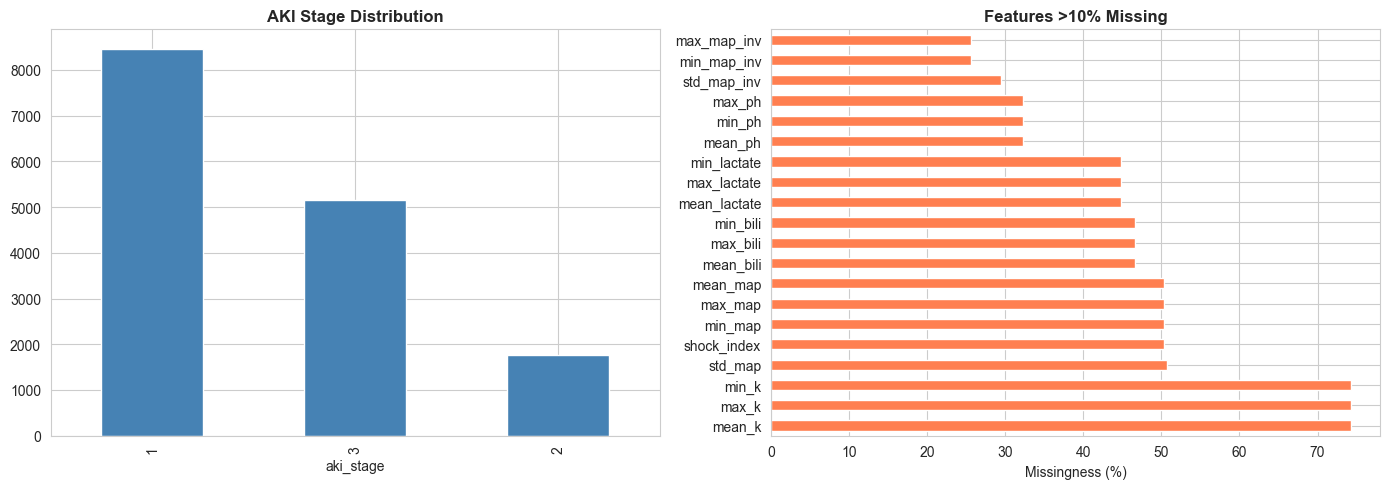

✓ Figure saved to /Users/zz005/Documents/github/Sepsis/output/data_summary.png


In [ ]:
print("\nData quality summary\n" + "="*60)

# Missingness
missing = (final.isnull().sum() / len(final) * 100).sort_values(ascending=False)
print("\nTop 15 missing features:")
print(missing.head(15))

# Feature types
print(f"\nNumeric features: {final.select_dtypes(include=np.number).shape[1]}")
print(f"Categorical features: {final.select_dtypes(include='object').shape[1]}")

# Sample
display(final.head())

# Visualize
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

final['aki_stage'].value_counts().plot(kind='bar', ax=ax[0], color='steelblue')
ax[0].set_title('AKI Stage Distribution', fontweight='bold')

missing[missing > 10].head(20).plot(kind='barh', ax=ax[1], color='coral')
ax[1].set_title('Features >10% Missing', fontweight='bold')
ax[1].set_xlabel('Missingness (%)')

plt.tight_layout()
plt.savefig(f"{RESULT_DIR}/data_summary.png", dpi=300)
plt.show()

print(f"✓ Figure saved to {RESULT_DIR}/data_summary.png")

In [10]:
# ============================================================
# COMPLETION
# ============================================================
print("\n" + "="*60)
print("✅ DATA EXTRACTION COMPLETE!")
print("="*60)


✅ DATA EXTRACTION COMPLETE!
